In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
import uproot.models
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/cernbox/Atmos_Pandora/apc_atmo_repo/Anatree/')
sys.path.append(f'/home/henrique/Documents/cernbox/Atmos_Pandora/apc_atmo_repo/personal/Henrique/Analysis/pida/')
from anatree_class import Anatree
from PIDA_class import PIDA
from  ana_tools import *
import plotly.graph_objects as go
from pida_functions import *


plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6],
                     })



In [23]:
def loaddata(path:str, entry_stop=None, forceit=False):
    parquet_path= path.replace(".root", ".parquet")
    if os.path.isfile(parquet_path) and not forceit:
        print(path, 'loaded parquet')
        df = pl.read_parquet(parquet_path)
        return df
    pid = PIDA(path, entry_stop=entry_stop)
    dfs:pl.DataFrame
    dfv:pl.DataFrame
    df:pl.DataFrame

    dfs = pid.dfsingles
    dfv = pid.dfvector
    dfp = pid.dfplanes

    df = dfs.join(dfv, on=selection_events())
    df = df.join(dfp, on=selection_events())
    df.write_parquet(file=parquet_path)
    return df
    
df = loaddata("data/pida_new.root", entry_stop=None, forceit=False)
dfshort = loaddata("data/pida_short.root", entry_stop=None, forceit=False)


data/pida_new.root loaded parquet
data/pida_short.root loaded parquet


In [24]:
dftrkg4 = getbestof(df)
dftrkg4short = getbestof(dfshort)
# dftrkg4 = dftrkg4.join(dftrkg4short.group_by(selection_events()).agg(), on=selection_events(), )
# dftrkg4 = dftrkg4.join(dftrkg4short.select(selection_events('trkId', 'trkpidpida_B')), on=selection_events('trkId'), how='left', coalesce=True)
# dftrkg4 = dftrkg4.with_columns(
#     pl.col('trkpidpida_B_right').fill_null(-1).alias('trksmallpida')
# ).drop('trkpidpida_B_right')
# dftrkg4 

In [26]:
dfall = dftrkg4.sort('trklen').filter(
    pl.col('ccnc_truth') == 0,
    pl.col('nuPDG_truth').abs() == 14
)
dfall = dfall.with_columns(
    pnc = pl.col('trkpurity_planes_B')*pl.col('trkcompleteness_planes_B'),
)


minP = 0.8
minC = 0.8
minV=minP*minC
if 'trkg4mother_planes_B' in dfall.columns:
    dfall_enough_pnc = dfall.group_by(selection_events()).agg(
        ((pl.col('trkg4pdg_planes_B').abs() == 13) & (pl.col('trkg4mother_planes_B')==0) & (pl.col('pnc') > minV) & (pl.col('trklen')>0)).any().alias('hasmu')
    )
else:
    dfall_enough_pnc = dfall.group_by(selection_events()).agg(
        ((pl.col('trkg4pdg_planes_B').abs() == 13) & (pl.col('pnc') > minV) & (pl.col('trklen')>0)).any().alias('hasmu')
    )
print(len(dfall_enough_pnc), len(dfall_enough_pnc.filter(~pl.col('hasmu'))), len(dfall_enough_pnc.filter(~pl.col('hasmu')))/len(dfall_enough_pnc))

dfall_enough_pnc = dfall_enough_pnc.filter(
    pl.col('hasmu')
).select(selection_events())

dfall = dfall.join(dfall_enough_pnc, on=selection_events()).sort(selection_events())
dfallmu = dfall.group_by(selection_events(), maintain_order=True).agg(
    pl.all().last()
)

235482 31621 0.1342820258023968


In [30]:
    
dfsimple = create_mucandidates(dfall)
dfmus = create_mucandidates_2(dfall, fineselection=False, afterfine=False)
dfmus_diff = create_mucandidates_2(dfall, fineselection=False, afterfine=False)
dfprselected = create_proton_candidate(dfmus)
dfprselected_diff = create_proton_candidate(dfmus_diff,
                                    # apply_shower_filter=True,
                                    #    cut_pida_easy=10,
                                    #    cut_pida_easy_shower=13,
                                    #    maxmom=1.5,
                                    #    maxcalo=0.8,
                                       )

dfprselected = join_pi_candidate(dfprselected, dfmus, 'pr')
dfprselected_diff = join_pi_candidate(dfprselected_diff, dfmus, 'pr')

dfprpiselected = create_pion_candidate(dfprselected,
                                       do_not_apply_cut_en=True,
                                       do_not_apply_small_cut_pida=True,
                                       do_not_apply_containement=True,
                                       othercuts=True,
                                       )
dfprpiselected_nocut = create_pion_candidate(dfprselected_diff,
                                       minimum_options_after_remove_mu=2,
                                       do_not_apply_cut_en=True,
                                       do_not_apply_small_cut_pida=True,
                                       do_not_apply_containement=True,
                                       othercuts=False,
                                       )

dfprpiselected = join_pi_candidate(dfprpiselected, dfprselected)
dfprpiselected_nocut = join_pi_candidate(dfprpiselected_nocut, dfprselected)
dfcomplex_en = complex_energy2(dfprpiselected, W="W", force_bigger_pr=False, do_not_force_bigger_pi=False)
dfcomplex_en_nocuts = complex_energy2(dfprpiselected_nocut, W="W", do_not_force_bigger_pi=False, force_bigger_pr=False)# force_murange=True)
dfcomplex_full = complex_energy2(dfprpiselected, W="W", do_not_force_bigger_pi=False, force_bigger_pr=False, return_full=True)
dfcomplex_full_nocuts = complex_energy2(dfprpiselected_nocut, W="W", do_not_force_bigger_pi=False, force_bigger_pr=False, return_full=True)

In [1]:
def plot_en_vs_en(Emu:pl.DataFrame,
                  lmethod,
                  x='enu_truth',
                  y='Etotal',
                  figsize=(8,6),
                  binsx=None,
                  binsy=None,
                  zscale='linear'
                  ):

    fig = plt.figure(figsize=figsize)
    if binsx is None:
        binsx = np.logspace(-1,2,200)
    if binsy is None:
        binsy = np.logspace(-1,2,200)
    # binsy = np.logspace(-1.1,np.log10(120),200)
    fontsize=18
    # fontsize='xx-large'
    plt.hist2d(Emu[x],Emu[y], bins=(binsx,binsy), norm=zscale, cmin=1, rasterized=True);
    # plt.plot([0,100],[0,100],'--', c='r')
    plt.xlabel('Neutrino Energy [GeV]', fontsize=fontsize)
    plt.ylabel(f'reco. E [GeV]', fontsize=fontsize)

    plt.yscale('log')
    plt.xscale('log')
    # plt.tick_params(labelsize=fontsize)

    cbar = plt.colorbar(pad=0.01)
    # cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    
    if lmethod != '':
        legend = plt.legend(frameon=True, title=lmethod, loc='upper left', bbox_to_anchor=(0,0.1,1,0.9))
        plt.setp(legend.get_title(),fontsize=fontsize)
    plt.plot([0,100],[0,100], 'r--', lw=1)
    # dunestyle.Preliminary(x=0.45, y=0.93, ax=plt.gca(), fontsize="xx-large")


dfsimple_en = simple_energy(dfsimple)
dfsimple_en = dfsimple_en.filter(
    True,
    # ~pl.col('trkIsContained')
    # pl.col('hasmu')
)
plot_en_vs_en(dfsimple_en, lmethod='Simple approach')
plot_en_vs_en(dfcomplex_en, lmethod='Complex approach')
# plot_en_vs_en(dfsimple_en, lmethod='Simple approach', x='lepen', y='Emu')


NameError: name 'pl' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


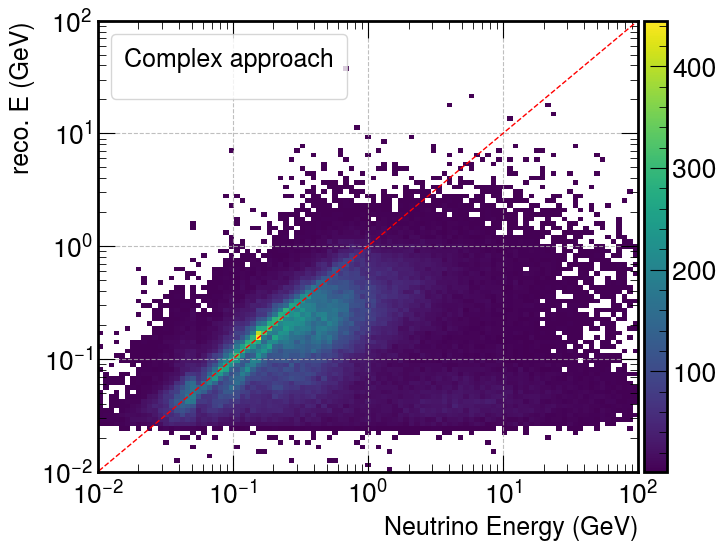

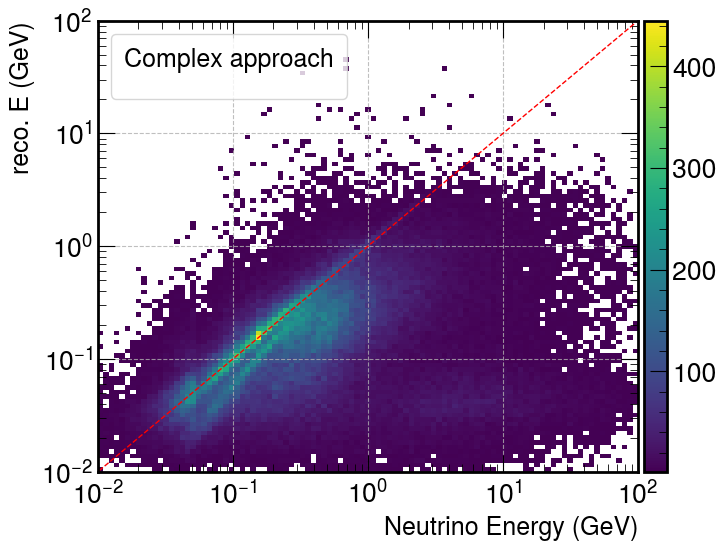

In [32]:
plot_en_vs_en(dfcomplex_full.filter(
                pl.col('selected_pi'),
                # pl.col('pnc')>0.8,
                # pl.col('trkIsContained'),
                # isparticle(2212),
                ),
              lmethod='Complex approach',
              x='trkg4K',
              y='Kpi',
              zscale='linear',
              binsx=np.logspace(-2,2,100),
              binsy=np.logspace(-2,2,100),
              )
plot_en_vs_en(dfcomplex_full_nocuts.filter(
                pl.col('selected_pi'),
                # pl.col('pnc')>0.8,
                # pl.col('trkIsContained'),
                # isparticle(2212),
                ),
              lmethod='Complex approach',
              x='trkg4K',
              y='Kpi',
              zscale='linear',
              binsx=np.logspace(-2,2,100),
              binsy=np.logspace(-2,2,100),
              )

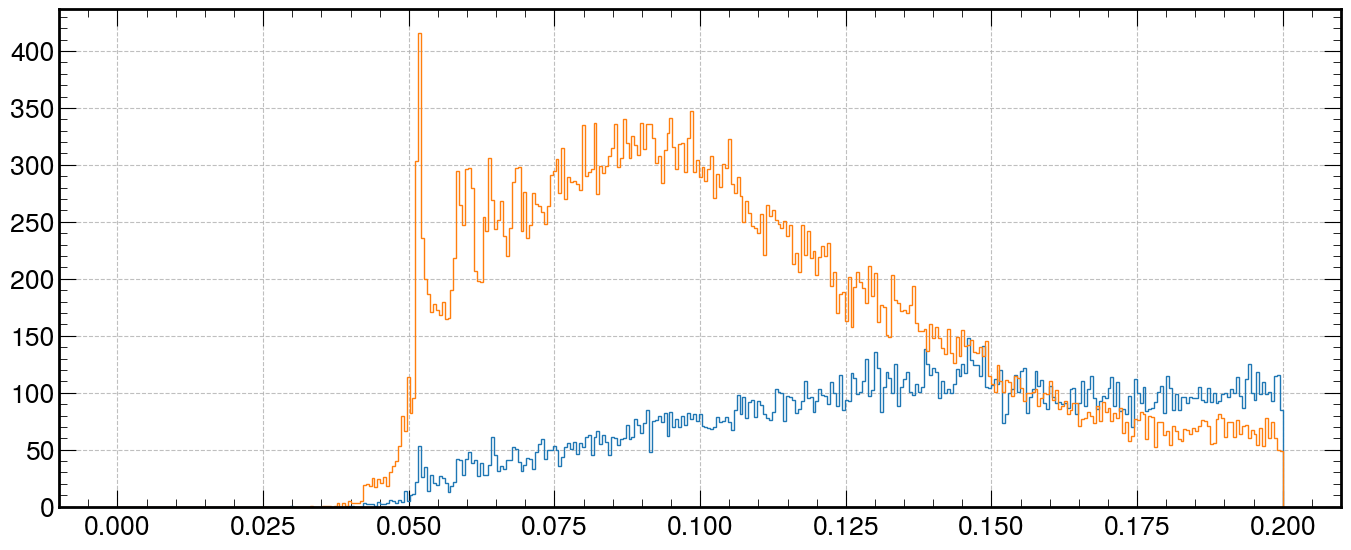

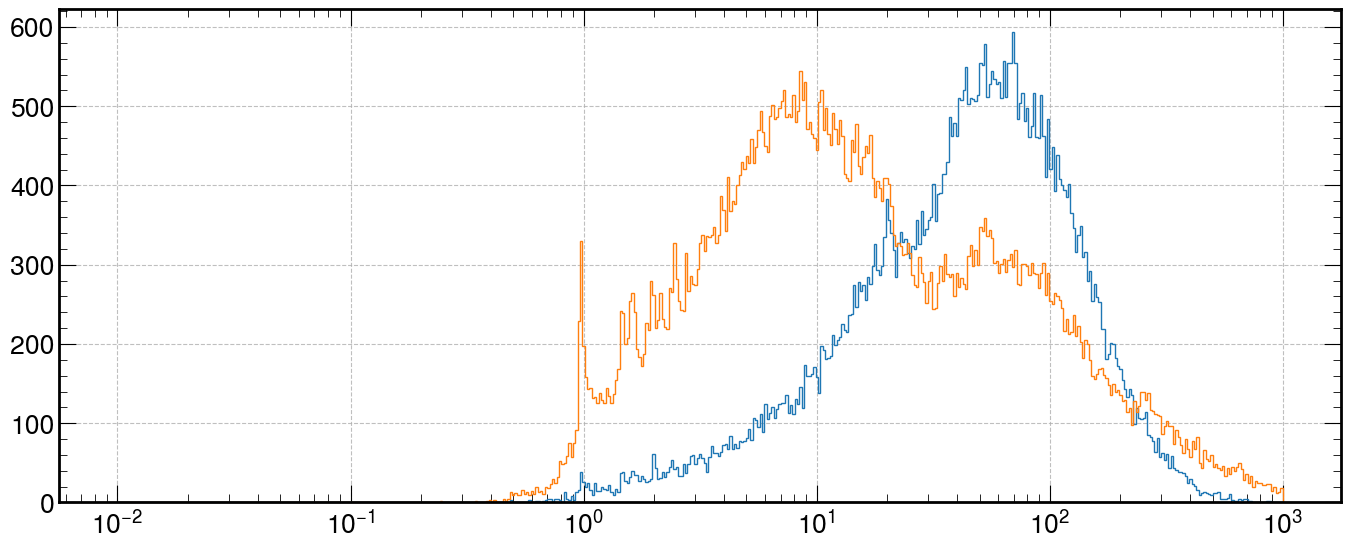

In [33]:
dfpi:pl.DataFrame
dfpi = dfcomplex_full_nocuts.filter(
    pl.col('selected_pi'),
    # pl.col('npi')<=3,
    # pl.col('trkmomllhd')>=0,
    # pl.col('pnc')>0.9,
).with_columns(
    Krange = pl.when(pl.col('trkmomrange_mu')>0).then(K_mu_cont()).otherwise(0)
).with_columns(
    diffpi = pl.col('Kpi')/trkcalo('W') - 1,
    diffpi_range = trkcalo('W') - pl.col('Krange')
# ).filter(
#     pl.col("diffpi")==0,
#     # trkcalo('W')==0
)
plt.hist(dfpi.filter(isparticle(211),  pl.col('trkIsContained'),)['trkmomrange_mu'], bins=np.linspace(-0,0.2,400), histtype='step');
plt.hist(dfpi.filter(~isparticle(211), pl.col('trkIsContained'),)['trkmomrange_mu'], bins=np.linspace(-0,0.2,400), histtype='step');
# plt.yscale('log')
plt.figure()
plt.hist(dfpi.filter(isparticle(211),  pl.col('trkIsContained'))['trklen'], bins=np.logspace(-2, 3, 500), histtype='step');
plt.hist(dfpi.filter(~isparticle(211), pl.col('trkIsContained'))['trklen'], bins=np.logspace(-2, 3, 500), histtype='step');
plt.xscale('log')

In [34]:
from scipy.stats import binned_statistic
def plot_res_scatter(x,
                    y,
                    actualx = None,
                    binsx = np.logspace(-1,2,200),
                    xlabel = 'Neutrino Energy [GeV]',
                    ylabel = '',
                    makefrac = True,
                    fmt='.',
                    infotype='std',
                    xscale='log',
                    yscale='linear',
                    loc='best',
                    leg_ancor=None,
                    title='',
                    xpre = 0.3,
                    ypre = 0.93,
                    # titlesize='xx-large',
                    titlesize=None,
                    legendsize=None,
                    **kwargs):
    x = x.filter(y>0)
    y = y.filter(y>0)
    plotx = x.to_numpy()
    if not actualx is None:
        plotx = [v for v in actualx]
    if makefrac:
        ploty = (y/x-1).to_numpy()
        # ploty = (x/y-1).to_numpy()
        # plotx = plotx[y>0]
        # ploty = ploty[y>0]
    else:
        ploty = y
    if infotype=='std':
        val, _, _ = binned_statistic(plotx, ploty, manual_std, binsx)
        val*=100
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        val[counts<=2] = np.nan
        yerr = np.array([s*100/np.sqrt(2*c-1) if c>1 else 0 for s,c in zip(std,counts)])
        yerr = np.sqrt(yerr**2 + 0**2)
        if ylabel == '':
            ylabel = r'Resolution [%]'
        if title=='':
            title = r'1$\sigma\times$100'
    else:
        val, _, _ = binned_statistic(plotx, ploty, infotype, binsx)
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        val[counts<=2] = np.nan
        yerr = [s/np.sqrt(c) if c>1 else 0 for s,c in zip(std,counts)]
        if ylabel == '':
            ylabel = r'$E_{reco}/E_{true}-1$'
        if title=='':
            title = 'Median'
    bins_center = 0.5*(binsx[:-1] + binsx[1:])
    bins_width = binsx[1:]- binsx[:-1]
    ax:plt.Axes
    ax = plt.gca()
    if 'capsize' in kwargs.keys():
        ax.errorbar(bins_center, val, xerr=(bins_width)/2, yerr=yerr, fmt=fmt, markersize=10, **kwargs)
    else:
        ax.plot(bins_center, val, fmt, **kwargs)
    plt.ylabel(ylabel,  )
    plt.xlabel(xlabel, )
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    legend = plt.legend(frameon=True, fancybox=False, bbox_to_anchor=leg_ancor,title=title, loc=loc, title_fontsize=titlesize, fontsize=legendsize)
    legend.get_frame().set_edgecolor('k')
    legend.get_frame().set_linewidth(0.6)
    plt.xlim(binsx[0],binsx[-1])
    plt.sca(ax)
    # dunestyle.Preliminary(x=xpre, y=ypre, ax=plt.gca(), fontsize="xx-large")

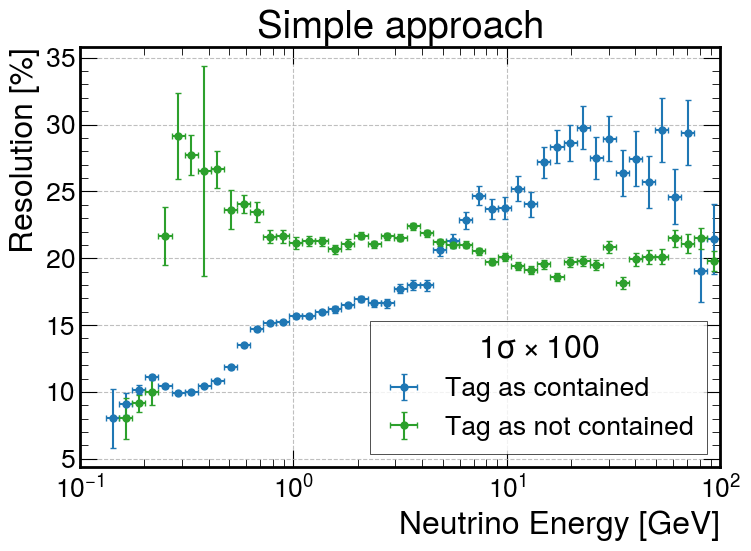

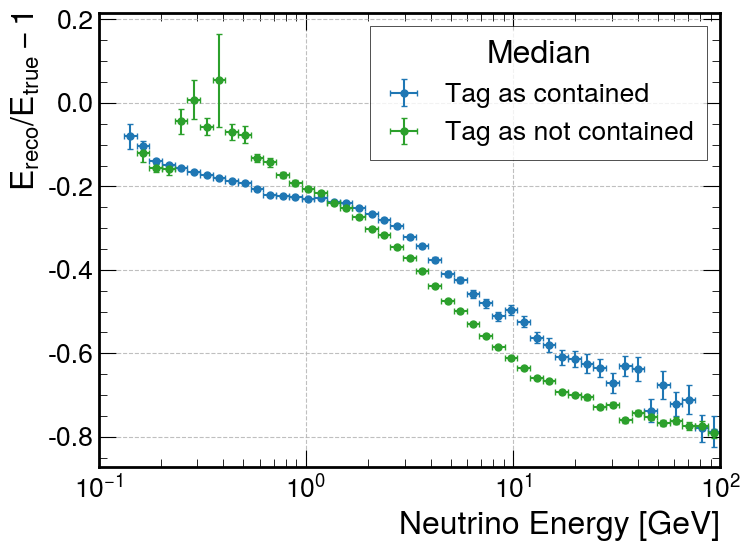

In [35]:
binsx= np.logspace(-1,2,50)
xscale='log'
capsize=2
label='LLHD'
plt.figure(figsize=(8,6))
x='lepmom'
y='Pmu'
x='enu_truth'
y='Etotal'
plot_res_scatter(
    dfsimple_en.filter(pl.col('trkIsContained'))[x],
    dfsimple_en.filter(pl.col('trkIsContained'))[y],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Tag as contained",
)
plot_res_scatter(
    dfsimple_en.filter(~pl.col('trkIsContained'))[x],
    dfsimple_en.filter(~pl.col('trkIsContained'))[y],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Tag as not contained",
    color='C2'
)
# plt.ylim(0,60)
plt.title('Simple approach')

plt.figure(figsize=(8,6))
plot_res_scatter(
    dfsimple_en.filter(pl.col('trkIsContained'))[x],
    dfsimple_en.filter(pl.col('trkIsContained'))[y],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Tag as contained",
    infotype='mean',
)
plot_res_scatter(
    dfsimple_en.filter(~pl.col('trkIsContained'))[x],
    dfsimple_en.filter(~pl.col('trkIsContained'))[y],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Tag as not contained",
    infotype='mean',
    color='C2'
)

# plt.savefig(f'./pdf/ereco_resolution_all_methods.pdf', dpi=300)

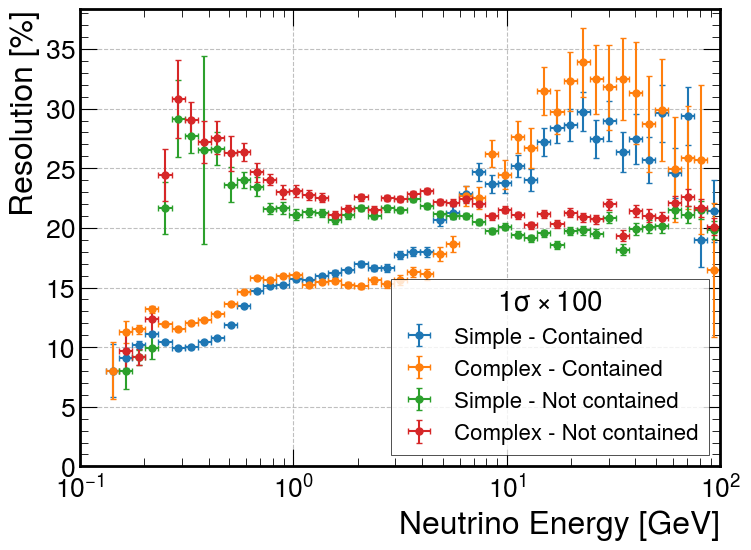

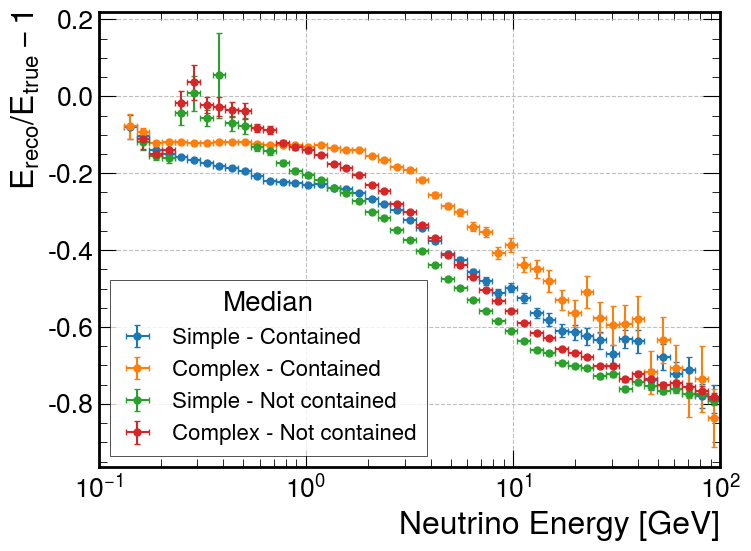

In [36]:
commonargs = dict(
    binsx= np.logspace(-1,2,50),
    xscale='log',
    capsize=2,
)
def the_res_scatter(labels = None, infotype="std", *args, **kargs):
    commonargs = dict(
        binsx= np.logspace(-1,2,50),
        xscale='log',
        capsize=2,
        legendsize=16,
        titlesize=20,
    )
    for k in commonargs.keys():
        if k not in kargs.keys():
            kargs[k] = commonargs[k]
    
    x='enu_truth'
    y='Etotal'
    if labels is None:
        labels = [ i for i, _ in enumerate(args)]
    plt.figure(figsize=(8,6))
    for df, label in zip(args, labels):
        plot_res_scatter(
            df.filter(pl.col('trkIsContained'))[x],
            df.filter(pl.col('trkIsContained'))[y],
            label=f"{label} - Contained",
            infotype=infotype,
            **commonargs,
        )
    for df, label in zip(args, labels):
        plot_res_scatter(
            df.filter(~pl.col('trkIsContained'))[x],
            df.filter(~pl.col('trkIsContained'))[y],
            label=f"{label} - Not contained",
            infotype=infotype,
            **commonargs,
        )
the_res_scatter(["Simple","Complex"], "std", dfsimple_en, dfcomplex_en, **commonargs)
plt.ylim(0,None)
the_res_scatter(["Simple","Complex"], "mean", dfsimple_en, dfcomplex_en, **commonargs)


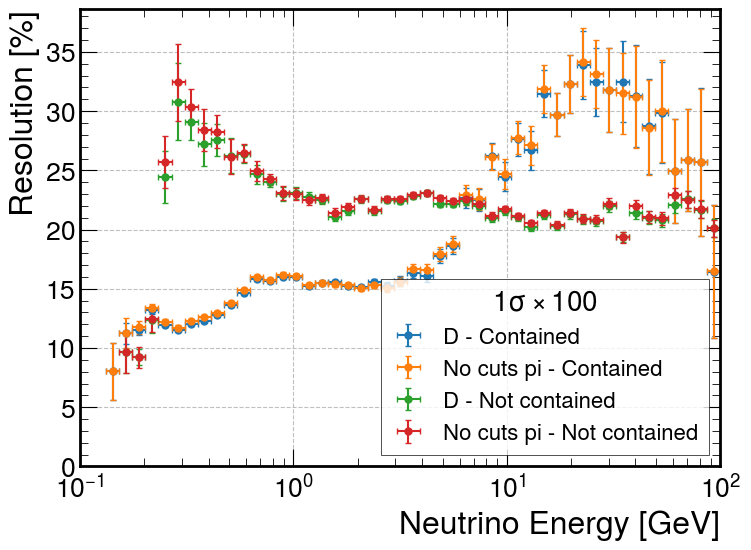

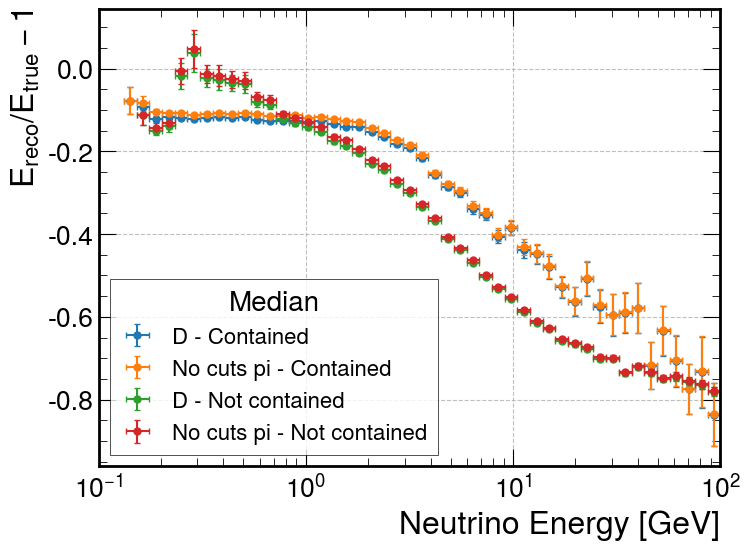

In [37]:
dfcomplex_en_nocuts2 = dfcomplex_en_nocuts.with_columns(
    # pl.col('Etotal')*1.01
)
the_res_scatter(["D","No cuts pi"], "std", dfcomplex_en, dfcomplex_en_nocuts2, **commonargs)
plt.ylim(0,None)
the_res_scatter(["D","No cuts pi"], "mean", dfcomplex_en, dfcomplex_en_nocuts2, **commonargs)
# plt.ylim(-0.15,0)

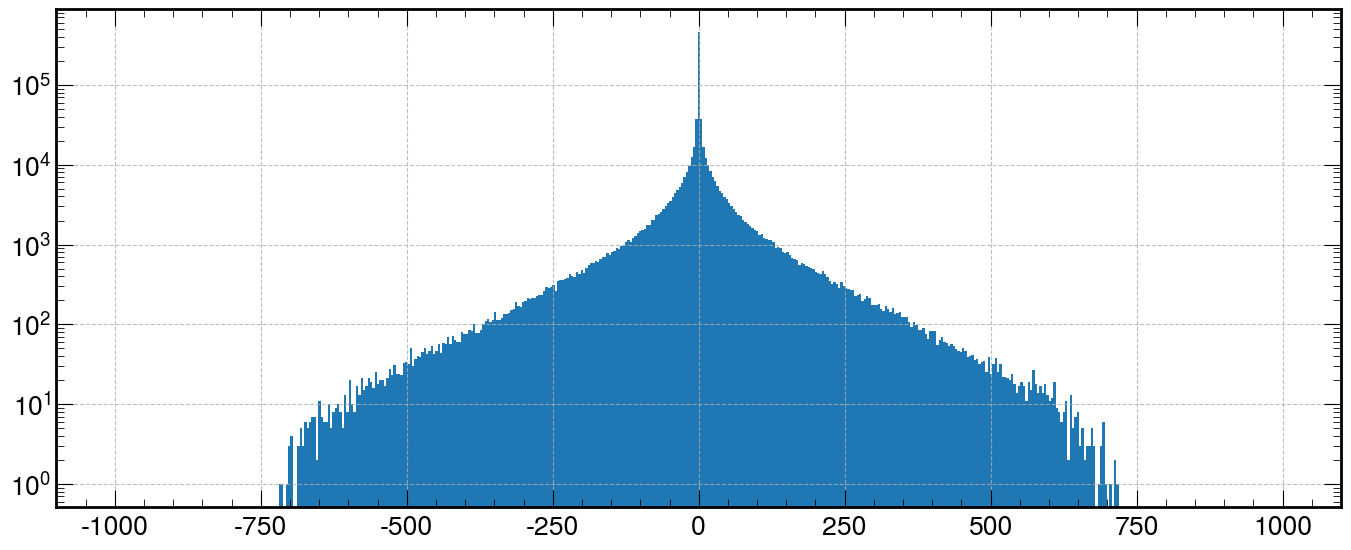

In [38]:
plt.hist(dfall['trkstartx']-dfall['recovtxx'], bins=np.linspace(-1000,1000,500));
plt.yscale('log')

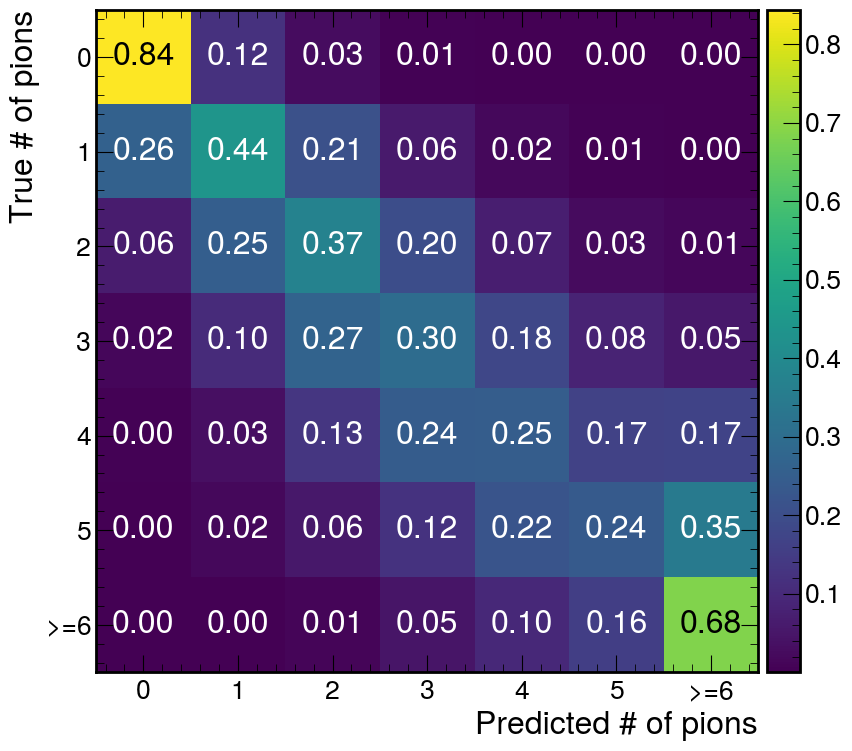

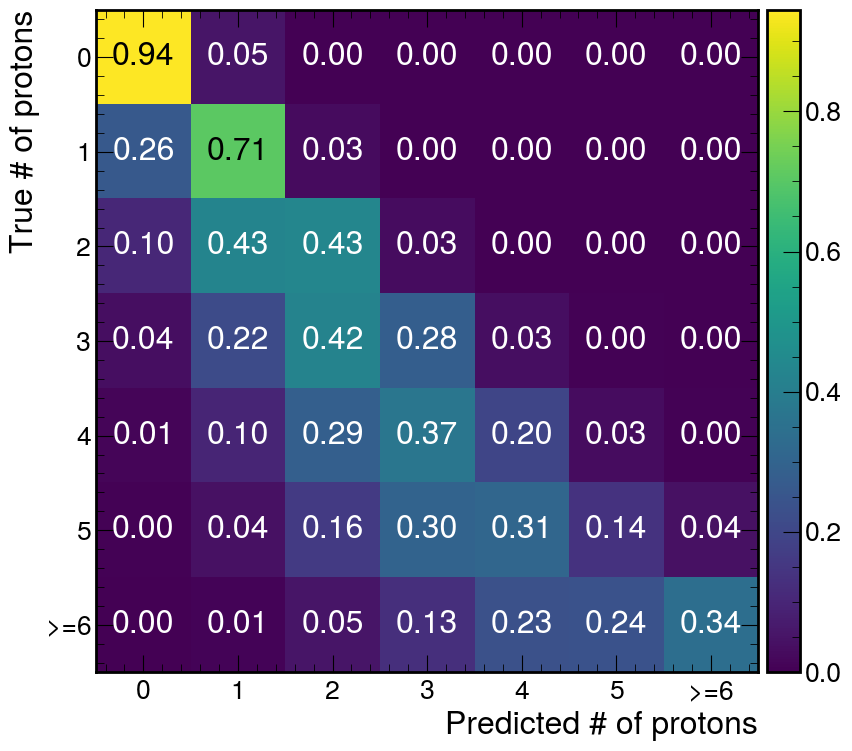

In [38]:

from sklearn import metrics
# dfmatches = dfprpiselected.filter(pl.col('trkPFPIsTrack')).group_by(selection_events(), maintain_order=True).agg(
dfmatches = dfcomplex_full.group_by(selection_events(), maintain_order=True).agg(
    pl.col('selected_pi').filter(pl.col('selected_pi')).len().cast(pl.Int32).alias('npi'),
    pl.col('trkg4pdg_planes_B').filter(isparticle(211)).len().cast(pl.Int32).alias('npitruth'),
    pl.col('trkg4id_planes_B').filter(isparticle(211)).unique().len().alias('npitunique'),
    pl.col('selected_pr').filter(pl.col('selected_pr')).len().cast(pl.Int32).alias('npr'),
    pl.col('trkg4pdg_planes_B').filter(isparticle(2212)).len().cast(pl.Int32).alias('nprtruth'),
    pl.col('trkg4id_planes_B').filter(isparticle(2212)).unique().len().alias('nprtunique'),
    pl.col('enu_truth').last(),
    pl.col('lepen').last(),
).with_columns(
    ratio_pi = ( pl.col('npi')-pl.col('npitruth') ),
    ratio_pr = ( pl.col('npr')-pl.col('nprtruth') )
)

nmax=6
classes = [0,1,2,3,4,5,">=6"]
dfmatches = dfmatches.with_columns(
    pl.when(pl.col('npi')>nmax).then(nmax).otherwise(pl.col('npi')).alias('npi'),
    pl.when(pl.col('npitruth')>nmax).then(nmax).otherwise(pl.col('npitruth')).alias('npitruth'),
    pl.when(pl.col('npr')>nmax).then(nmax).otherwise(pl.col('npr')).alias('npr'),
    pl.when(pl.col('nprtruth')>nmax).then(nmax).otherwise(pl.col('nprtruth')).alias('nprtruth'),
)

confusion_matrix_pi = metrics.confusion_matrix(dfmatches['npitruth'], dfmatches['npi'])
# print(confusion_matrix_pi)
# print(confusion_matrix_pi.sum())
confusion_matrix_pi = np.array([ line/total for line, total in zip(confusion_matrix_pi, confusion_matrix_pi.sum(1))])
# print(confusion_matrix_pi)

fig, ax = plt.subplots(figsize=(10,8))
cb = ax.imshow(confusion_matrix_pi)
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        color='white' if confusion_matrix_pi[i,j] < 0.5 else 'black'
        # color='green' if confusion_matrix_pi.transpose()[j,i] < 0.5 else 'white'
        ax.annotate(f'{confusion_matrix_pi[i,j]:.2f}', (j,i), 
                    color=color, va='center', ha='center')
ax.grid(False)
plt.colorbar(cb, ax=ax, pad=0.01)
plt.ylabel('True # of pions')
plt.xlabel('Predicted # of pions')
plt.show()

confusion_matrix_pr = metrics.confusion_matrix(dfmatches['nprtruth'], dfmatches['npr'])
confusion_matrix_pr = np.array([ line/total for line, total in zip(confusion_matrix_pr, confusion_matrix_pr.sum(1))])

fig, ax = plt.subplots(figsize=(10,8))
cb = ax.imshow(confusion_matrix_pr)
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        color='white' if confusion_matrix_pr[i,j] < 0.5 else 'black'
        # color='green' if confusion_matrix_pr.transpose()[j,i] < 0.5 else 'white'
        ax.annotate(f'{confusion_matrix_pr[i,j]:.2f}', (j,i), 
                    color=color, va='center', ha='center')
ax.grid(False)
plt.colorbar(cb, ax=ax, pad=0.01)
plt.ylabel('True # of protons')
plt.xlabel('Predicted # of protons')
plt.show()